For regular chunked stochastic forward simulation, as with the MPR backend, we would create the buffer, and step through it, rewriting the noise samples with the computed time series, something like this

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as pl

import jax.numpy as np
import jax
from jax.test_util import check_grads

keys = jax.random.split(jax.random.PRNGKey(0), 10)
nn = 84
weights = np.abs(jax.random.normal (keys[0], (nn, nn)))+0.5
lengths = jax.random.randint(keys[1], (nn, nn), 0, 255)
nh = lengths.max() + 1
nt = 100
buffer = jax.random.normal(keys[2], (nn, nh + nt))
nn = weights.shape[0]
ns = np.tile(np.arange(nn),(nn,1))

In [2]:
@jax.jit
def run(buffer):
    # TODO convert to scan?
    for t in range(nt):
        x_t = np.mean(weights*buffer[ns, nh + t - lengths], axis=1)
        buffer = buffer.at[:, nh + t].set(x_t)
    return buffer

b1 = run(buffer)
%timeit run(buffer)

1.15 ms ± 9.73 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [3]:
loss = lambda b: np.sum(np.square(b1 - run(b)))
gloss = jax.jit(jax.grad(loss))
gloss(b1).shape

%timeit gloss(b1+1)

(84, 355)

In [5]:
# n=1 run 16us & gloss 52us
# n=10 run 118us & gloss 590us
# n=100 run 1150 us & gloss 32700us

The tricky bit with a scan is the carry,

In [6]:
jax.lax.scan?

In [157]:
def make_run(nt):
    def op(buffer, t):
        x_t = np.mean(weights*buffer[ns, nh + t - lengths], axis=1)
        buffer = buffer.at[:, nh + t].set(x_t)
        return buffer, x_t
    @jax.jit
    def run(buffer):
        b, x = jax.lax.scan(op, buffer, np.r_[:nt])
        return b
    return op, run

op, run2 = make_run(nt)
run2(buffer).shape
%timeit run2(buffer)

1.33 ms ± 3.17 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [158]:
loss2 = lambda b: np.sum(np.square(b1 - run2(b)))
gloss2 = jax.jit(jax.grad(loss2))
gloss2(b1).shape
%timeit gloss2(b1+1)

5.34 ms ± 8.71 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


About 4x slower.. could it be any better with custom vjp? well let''s look at what it's actually doing:

In [9]:
f = lambda b: np.sum(np.square(op(b,0)[0]))

jax.make_jaxpr(jax.grad(f))(b1)

{ lambda a:i32[] b:i32[84,84] c:i32[84,84] d:f32[84,84]; e:f32[84,355]. let
    f:i32[] = add a 0
    g:i32[84,84] = sub f b
    h:bool[84,84] = lt c 0
    i:i32[84,84] = add c 84
    j:i32[84,84] = select_n h c i
    k:bool[84,84] = lt g 0
    l:i32[84,84] = add g 355
    m:i32[84,84] = select_n k g l
    n:i32[84,84,1] = broadcast_in_dim[
      broadcast_dimensions=(0, 1)
      shape=(84, 84, 1)
    ] j
    o:i32[84,84,1] = broadcast_in_dim[
      broadcast_dimensions=(0, 1)
      shape=(84, 84, 1)
    ] m
    p:i32[84,84,2] = concatenate[dimension=2] n o
    q:f32[84,84] = gather[
      dimension_numbers=GatherDimensionNumbers(offset_dims=(), collapsed_slice_dims=(0, 1), start_index_map=(0, 1))
      fill_value=None
      indices_are_sorted=False
      mode=GatherScatterMode.PROMISE_IN_BOUNDS
      slice_sizes=(1, 1)
      unique_indices=False
    ] e p
    r:f32[84,84] = mul d q
    s:f32[84] = reduce_sum[axes=(1,)] r
    t:f32[84] = div s 84.0
    u:i32[] = add a 0
    v:bool[] = 

This is interesting because it tells us that we have gather, scatter, scatter, gather here, to compute the gradient.  Can't some of that work be kept from the forward pass?  In any case, the jaxpr here is useful to understand what those clever transformations liek `jax.grad` are doing.

## custom vjp of scan `op`

If we have a scan forward, we have to have a scan backward, but we can amortize the cost by saving some of the work?

Read https://jax.readthedocs.io/en/latest/notebooks/Custom_derivative_rules_for_Python_code.html carefully first, and make sure we know how to handle multiple inputs & outputs,

In [10]:
# simple example with two outputs, how to do?
@jax.custom_vjp
def foo(a, b):
    return 2*a+b, 3*a+0.5*b

def foo_fwd(a, b):
    return foo(a, b), None

def foo_bwd(res, g):
    g_1, g_2 = g
    return (2*g[0]+3*g[1], g[0] + 0.5*g[1])

foo.defvjp(foo_fwd, foo_bwd)

def bar(a, b):
    c, d = foo(a, b)
    return 2*c + 3*d

jax.grad(bar, [0,1])(3.,4.)

jax.test_util.check_grads(bar, (3.0, 4.0), order=1, modes=('rev',))

With that simple example in mind we can handle `op(buffer,t) -> (c, x)`, though the data flow is more complicated, so the resulting backwards pass is also:

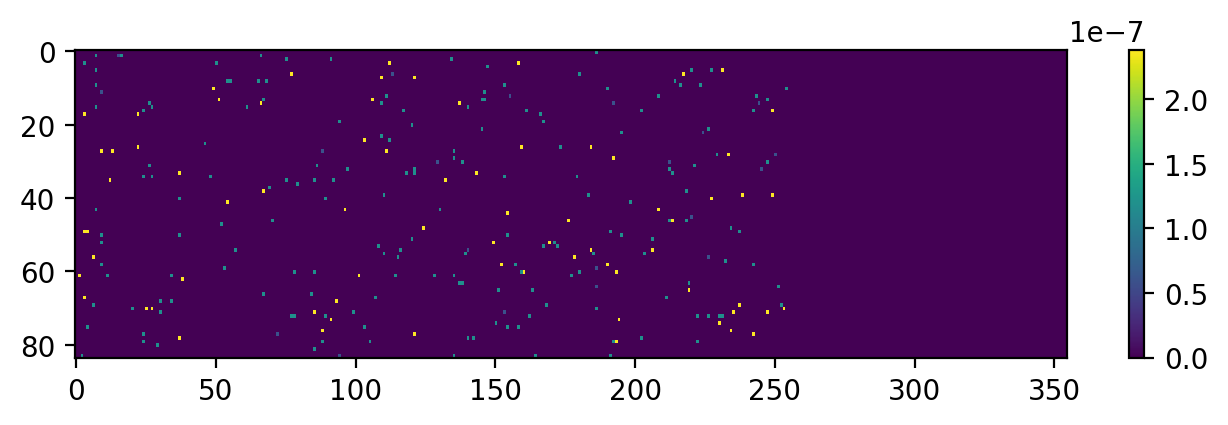

In [156]:
import numpy as onp

def make_bar(custom_bwd=False):
    
    cvjp = jax.custom_vjp if custom_bwd else (lambda f: f)
    
    @cvjp
    def op(buffer, t):
        nx = np.sum(weights*buffer[ns, nh + t - lengths], axis=1)
        # only seems to be required with check_grads below
        if isinstance(buffer, onp.ndarray):
            buffer = np.array(buffer)
        buffer = buffer.at[:, nh + t + 1].set(nx)
        return buffer, nx

    if custom_bwd:
        def op_fwd(buffer, t):
            return op(buffer, t), (t,)

        def op_bwd(res, g):
            t, = res
            g_buf, g_x = g  # shaped (nn, nh+nt) & (nn, )
            
            # buffer[:, nh + t + 1] = nx
            g_nx = g_x + g_buf[:, nh + t + 1]
            
            # output is independent of the buffer at time t+1 (wtf! but true)
            g_buf = g_buf.at[:, nh + t + 1].set(0)
            
            # x_t = np.sum(weights*buffer[ns, nh + t - lengths], axis=1)
            g_buf = g_buf.at[ns, nh + t - lengths].add(weights * g_nx[:, None])
            
            # t is integer, no gradient possible
            g_t = None  

            # done
            return g_buf, g_t

        op.defvjp(op_fwd, op_bwd)

    # np.sum(x) works
    # np.sum(b) works too
    def bar(b):
        b, x = op(b, 0)
        return 0.3*np.sum(b)+0.2*np.sum(x)
    
    return bar

bar1 = make_bar(False)
bar2 = make_bar(True)

jax.grad(bar1)(b1)
jax.test_util.check_grads(bar1, (b1, ), order=1, modes=('rev',))

jax.grad(bar2)(b1);
try:
    jax.test_util.check_grads(bar2, (b1, ), order=1, modes=('rev',))
except Exception as e:
    print(e)

gb1 = jax.grad(bar1)(b1)
gb2 = jax.grad(bar2)(b1)

pl.figure(figsize=(8,2)); pl.imshow(np.abs(gb1-gb2), aspect='auto', interpolation='none'); pl.colorbar()

Now it's working let's see if it was worthwhile:

In [159]:
# copy-pasted from above w/ our custom vjp inserted
def make_run(nt):
    @jax.custom_vjp
    def op(buffer, t):
        nx = np.sum(weights*buffer[ns, nh + t - lengths], axis=1)
        buffer = buffer.at[:, nh + t + 1].set(nx)
        return buffer, nx

    def op_fwd(buffer, t): 
        b, x = op(buffer, t)
        return (b, x), (t, )

    def op_bwd(res, g):
        t,  = res
        g_buf, g_x = g  # shaped (nn, nh+nt) & (nn, )
        g_nx = g_x + g_buf[:, nh + t + 1]
        # output is independent of the buffer at time t+1 (wtf! but true)
        g_buf = g_buf.at[:, nh + t + 1].set(0)  
        g_buf = g_buf.at[ns, nh + t - lengths].add(weights * g_nx[:, None])
        return g_buf, None

    op.defvjp(op_fwd, op_bwd)

    @jax.jit
    def run(buffer):
        b, x = jax.lax.scan(op, buffer, np.r_[:nt])
        return b
    return op, run

op, run2 = make_run(nt)
run2(buffer).shape
%timeit run2(buffer)

loss2 = lambda b: np.sum(np.square(b1 - run2(b)))
gloss2 = jax.jit(jax.grad(loss2))
gloss2(b1).shape
%timeit gloss2(b1+1)

1.32 ms ± 8.57 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
4.82 ms ± 14.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


So it's about 10% faster to implement by hand.. perhaps due to non stride 1 access on `g_buf`?  Removing those (and making the result incorrect) drops from 4.9 ms to 3.2 ms, which is still >2x the forward pass, suggesting unnecessary memory overhead; and using linear indexing would help as well.

In [164]:
for nt in [10, 100, 1000]:
    print('============', nt)
    buffer = jax.random.normal(keys[2], (nn, nh + nt))
    op, run2 = make_run(nt)
    run2(buffer)
    %timeit run2(buffer)
    loss2 = lambda b: np.sum(np.square(buffer - run2(b)))
    gloss2 = jax.jit(jax.grad(loss2))
    %timeit gloss2(buffer+1)

============ 10
135 µs ± 1.37 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
463 µs ± 585 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
============ 100
1.33 ms ± 11.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
4.81 ms ± 6.13 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
============ 1000
13.1 ms ± 60.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
54.1 ms ± 255 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


The last thing to try is to do the `defvjp` on top of the scan,

In [179]:
def make_run(nh, nt):
    
    def op(buffer, t):
        nx = np.sum(weights*buffer[ns, nh + t - lengths], axis=1)
        buffer = buffer.at[:, nh + t + 1].set(nx)
        return buffer, nx

    def op_fwd(buffer, t): 
        b, x = op(buffer, t)
        return (b, x), (t, )

    def op_bwd(res, g):
        t,  = res
        g_buf, g_x = g  # shaped (nn, nh+nt) & (nn, )
        g_nx = g_x + g_buf[:, nh + t + 1]
        # output is independent of the buffer at time t+1 (wtf! but true)
        g_buf = g_buf.at[:, nh + t + 1].set(0)  
        g_buf = g_buf.at[ns, nh + t - lengths].add(weights * g_nx[:, None])
        return g_buf, None

    # op.defvjp(op_fwd, op_bwd)
    
    ts_fwd = np.r_[:nt]
    ts_rev = ts_fwd[::-1]
    
    @jax.custom_vjp
    def run(buffer):
        b, x = jax.lax.scan(op, buffer, ts_fwd)
        return b
    
    # so with this run, we don't worry about gradients for x
    def run_fwd(buffer):
        buffer = run(buffer)
        return buffer, ()

    g_x_bwd = np.zeros((nn,))
    
    def run_bwd_op(g_buf, t):
        g_buf, _ = op_bwd((t, ), (g_buf, g_x_bwd))
        return g_buf, g_x_bwd
    
    def run_bwd(res, g_buffer):
        g_buffer, _ = jax.lax.scan(run_bwd_op, g_buffer, ts_rev)
        return g_buffer,
    
    run.defvjp(run_fwd, run_bwd)
    
    return run


nh, nt = 255, 100
buffer = jax.random.normal(keys[2], (nn, nh + nt))
run2 = make_run(nh, nt)
run2(buffer).shape
%timeit run2(buffer)

loss2 = lambda b: np.sum(np.square(buffer - run2(b)))
gloss2 = jax.jit(jax.grad(loss2))
gloss2(buffer).shape
%timeit gloss2(buffer+1)

1.51 ms ± 9.29 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
4.4 ms ± 9.01 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


So writing out full backwards pass is still 3x the forwards pass, close the the 2x we might want (20% faster than original).  If we write one big function what happens?

In [194]:
def make_run_fwd_bwd(nt, ns, nh, weights, lengths): 
    @jax.jit
    def run_fwd(buffer):
        for t in range(nt):
            nx = np.sum(weights*buffer[ns, nh + t - lengths], axis=1)
            buffer = buffer.at[:, nh + t + 1].set(nx)
        return buffer

    @jax.jit
    def run_bwd(g_buf):
        for t in reversed(range(nt)):
            g_nx = g_buf[:, nh + t + 1]
            # output is independent of the buffer at time t+1
            g_buf = g_buf.at[:, nh + t + 1].set(0)  
            g_buf = g_buf.at[ns, nh + t - lengths].add(weights * g_nx[:, None])
        return g_buf
    return run_fwd, run_bwd

run_fwd, run_bwd = make_run_fwd_bwd(nt, ns, nh, weights, lengths)
run_fwd(buffer)
%timeit run_fwd(buffer)

g_buf = np.ones_like(buffer)
run_bwd(g_buf)
%timeit run_bwd(g_buf)

1.17 ms ± 3.44 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
2.64 ms ± 5.07 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


It's a little bit faster when we let the JIT work across loop iterations, though diminishing returns at 10 to 20 iterations.  The bwd is about two times slower: the `add` requires a read in addition to a write.

That the JIT can speed things up with multiple iterations available suggests that we could do away with the custom bwd completely by doing a few iterations within the scan op:

In [235]:
def make_run(nT):
    @jax.jit
    def op(buffer, T):
        for t in range(10):
            x_t = np.sum(weights[:, :, None]*buffer[ns, nh + T*10 + t - lengths], axis=1)
            buffer = buffer.at[:, nh + t].set(x_t)
        return buffer, x_t
    @jax.jit
    def run(buffer):
        b, _ = jax.lax.scan(op, buffer, np.r_[:nT])
        return b
    return run

run2 = make_run(nt//10)
run2(buffer).shape
%timeit run2(buffer)

17.7 ms ± 133 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [211]:
loss = lambda b: np.sum(np.square(buffer - run2(b)))
gloss = jax.jit(jax.grad(loss))
gloss(buffer).shape
%timeit gloss(buffer+1)

5.43 ms ± 18.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


So that idea doesn't pan out.  It seems like the best option is to choose one of the following

- let jax diff through it, lose 2x
- use full custom impl, gain 2x but require checking with test_grads

For full on flexibility prototyping it's good to set custom bwd aside, leave it as an exercise for motivated user to add in afterward.

In [219]:
steps_per_s = 100 / 1.32 * 1e3
steps_per_s

75757.57575757575

That's roughly same speed as FastTVB, so we're in the ballpark.  Let's see what kinds of batching we can do.

In [243]:
nb = 4
nh, nt = 255, 100
buffer = jax.random.normal(keys[2], (nn, nh + nt, nb))
# run2b = jax.vmap(run2, 2, 2)
# run2b(buffer).shape
# %timeit run2b(buffer)

interesting this seems to do some multithreading with larger enough batch sizes, does a little better than linear speed up.

In [244]:
# this requires the weights[:,:,None] above
run2(buffer).shape
%timeit run2(buffer)

2.94 ms ± 132 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Seems like this consistently buys 2x speed up for free (on this m1 cpu) but probably a lot more on GPU, *to be tested*.